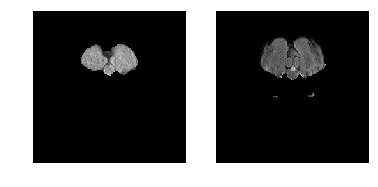

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('../../Class/BraTS2020_png_training/Training_flair_001/BraTS20_Training_001_flair.ni_z020.png'))
label = np.asarray(Image.open('../../Class/BraTS2020_png_validation/Validation_flair_001/BraTS20_Validation_001_flair.ni_z020.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

In [39]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

In [40]:
def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('../../Class/BraTS2020_png_training/Training_flair_001/*.png'))
    train_label_filenames = sorted(glob.glob('../../Class/BraTS2020_png_training/Training_seg_001/*.png'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('../../Class/BraTS2020_png_validation/Validation_flair_001/*.png'))
    val_label_filenames = sorted(glob.glob('../../Class/BraTS2020_png_validation/Validation_seg_001/*.png'))
    val = create_dataset(val_img_filenames, val_label_filenames)

    return train, val

In [41]:
train, val = create_datasets()

print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	155
	valid:	155


In [42]:
import chainer
import chainer.functions as F
import chainer.links as L

class MultiLayerPerceptron(chainer.Chain):

    def __init__(self, out_h, out_w):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 100)
            self.l3 = L.Linear(100, out_h * out_w)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        n = x.shape[0]

        return h.reshape((n, 1, self.out_h, self.out_w))

In [43]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1):
    # 先程定義したモデルを使用
    model = MultiLayerPerceptron(out_h=240, out_w=240)

    # ピクセルごとの二値分類なので，目的関数にSigmoid cross entropyを，
    # 精度をはかる関数としてBinary accuracyを指定しています
    train_model = L.Classifier(
        model, lossfun=F.sigmoid_cross_entropy, accfun=F.binary_accuracy)

    # 最適化手法にAdamを使います
    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    # データセットから，指定したバッチサイズ数のデータ点をまとめて取り出して返すイテレータを定義します
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    # イテレータからデータを引き出し，モデルに渡して，目的関数の値を計算し，backwardしてパラメータを更新，
    # までの一連の処理を行う updater を定義します
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # 様々な付加機能をExtensionとして与えられるTrainerを使います
    trainer = training.trainer.Trainer(updater, stop)

    logging_attributes = [
        'epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy']
    trainer.extend(extensions.LogReport(logging_attributes))
    trainer.extend(extensions.PrintReport(logging_attributes))
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(extensions.Evaluator(val_iter, optimizer.target, device=device), name='val')

    return trainer

In [44]:
trainer = create_trainer(64, train, val, (20, 'epoch'), device =-1)
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy
1           0.734381    0.513624       0.689499       0.612588           
2           0.688853    0.606996       0.688384       0.666698           
3           0.680117    0.628886       0.668388       0.666933           
4           0.660062    0.641151       0.651068       0.686724           
5           0.636853    0.688565       0.615421       0.72311            
6           0.592066    0.705756       0.586911       0.749601           
7           0.559306    0.736251       0.5515         0.775666           
8           0.504831    0.770602       0.486496       0.812979           
9           0.446433    0.81255        0.439121       0.835674           
10          0.370016    0.833953       0.368079       0.867285           
11          0.299218    0.862451       0.322398       0.884474           
12          0.281226    0.887947       0.259473       0.904912           
13          0.173255    0.90139        0

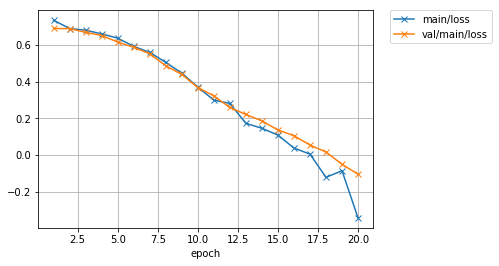

In [45]:
from IPython.display import Image
Image('result/loss.png')

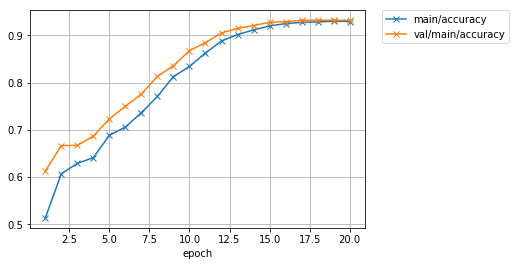

In [46]:
Image('result/accuracy.png')

In [47]:
from chainer import cuda
from chainercv import evaluations


def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor
     # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        pred = model(img[np.newaxis])
        pred = pred.data[0, 0] > 0
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])

evaluate(trainer, val, device =0)


Pixel Accuracy: 0.9271012544802867
mIoU: 0.2424714632373934


/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
